tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
GPU: NVIDIA GeForce RTX 2060
Memory Allocated: 0.00 MB
Memory Cached: 0.00 MB


Epoch 1/3: 100%|██████████| 766/766 [02:03<00:00,  6.19it/s, loss=0.0428]



Epoch 1:
Average training loss: 0.2695
Training accuracy: 0.9130
Average test loss: 0.1962
Test accuracy: 0.9328


Epoch 2/3: 100%|██████████| 766/766 [02:03<00:00,  6.20it/s, loss=0.317] 



Epoch 2:
Average training loss: 0.1620
Training accuracy: 0.9541
Average test loss: 0.1623
Test accuracy: 0.9602


Epoch 3/3: 100%|██████████| 766/766 [02:03<00:00,  6.19it/s, loss=0.369]  



Epoch 3:
Average training loss: 0.1252
Training accuracy: 0.9657
Average test loss: 0.1552
Test accuracy: 0.9608


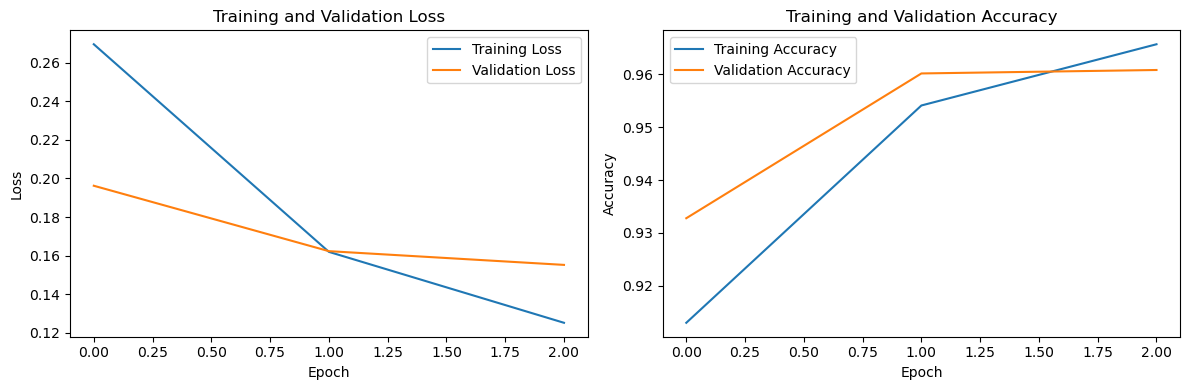

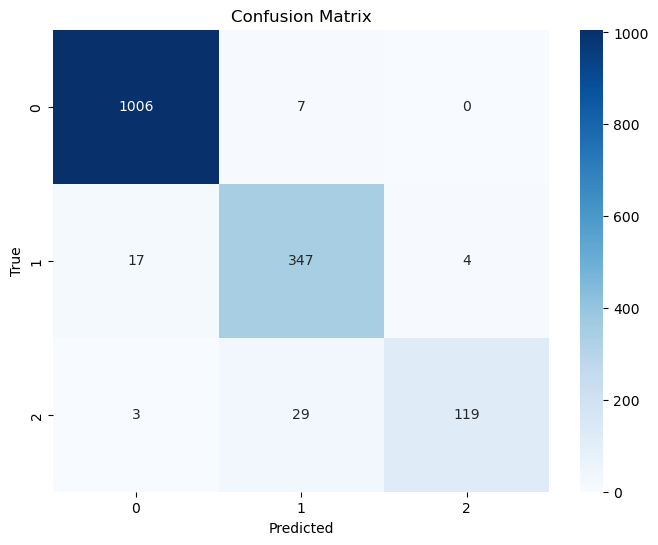

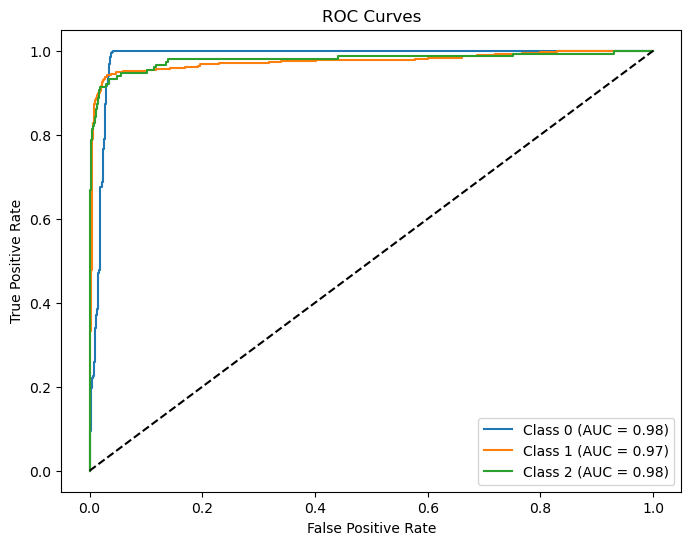

Training Time: 399.78 seconds
Inference Time: 9.71 seconds

Metrics:
Accuracy: 0.9608
Precision: 0.9613
Recall: 0.9608
F1-Score: 0.9601
Sensitivity: 0.9608
Specificity: 0.9613


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import time
from tqdm import tqdm
import gc

max_samples = 10000
df = pd.read_csv('combined_all_news.csv')
df = df.sample(n=min(len(df), max_samples), random_state=42)

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

X = df['İçerik Stemmed'].values
y = df['Sentiment_Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def tokenize_data(texts, max_length=128):
    return tokenizer(
        texts.tolist(), 
        padding=True, 
        truncation=True, 
        max_length=max_length,
        return_tensors="pt"
    )

train_encodings = tokenize_data(X_train)
test_encodings = tokenize_data(X_test)

train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(y_train)
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test)
)

batch_size = 8 if torch.cuda.is_available() else 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 3
gradient_accumulation_steps = 4

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), 
                       desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for step, batch in progress_bar:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / gradient_accumulation_steps
        
        loss.backward()
        
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        total_train_loss += loss.item() * gradient_accumulation_steps
        
        predictions = torch.argmax(outputs.logits, dim=1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
        progress_bar.set_postfix({'loss': loss.item() * gradient_accumulation_steps})
    
    if len(train_loader) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    total_test_loss = 0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            total_test_loss += loss.item()
            
            predictions = torch.argmax(outputs.logits, dim=1)
            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = test_correct / test_total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f'\nEpoch {epoch+1}:')
    print(f'Average training loss: {avg_train_loss:.4f}')
    print(f'Training accuracy: {train_accuracy:.4f}')
    print(f'Average test loss: {avg_test_loss:.4f}')
    print(f'Test accuracy: {test_accuracy:.4f}')
    
    torch.cuda.empty_cache()
    gc.collect()

training_time = time.time() - start_time

start_inference_time = time.time()
model.eval()

test_batch_size = 16 if torch.cuda.is_available() else 8
all_logits = []
all_predictions = []

with torch.no_grad():
    for i in range(0, len(test_encodings['input_ids']), test_batch_size):
        batch_input_ids = test_encodings['input_ids'][i:i+test_batch_size].to(device)
        batch_attention_mask = test_encodings['attention_mask'][i:i+test_batch_size].to(device)
        
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        
        all_logits.append(logits.cpu())
        all_predictions.extend(predictions.cpu().numpy())
        
        del outputs, logits, predictions
        torch.cuda.empty_cache()

y_pred_proba = torch.softmax(torch.cat(all_logits, dim=0), dim=1).numpy()
y_pred = all_predictions

inference_time = time.time() - start_inference_time

y_true = y_test

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score((y_test == i).astype(int), y_pred_proba[:, i])

cm = confusion_matrix(y_true, y_pred)

if len(np.unique(y_true)) == 2:
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
else:
    sensitivity = recall
    specificity = precision

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")